<a href="https://colab.research.google.com/github/majdkhalife/StockPredictor/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup env

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import Callback
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm

## Choose stock

In [14]:
stock_data = yf.download("AMD", start="2022-01-01")
get_stock_data = pd.DataFrame(stock_data)

[*********************100%***********************]  1 of 1 completed


## Plot opening and closing prices

In [15]:
def compute_rsi(series, window=14):
    """
    Compute the 14-day Relative Strength Index (RSI).
    Basic formula:
      RSI = 100 - [100 / (1 + RS)]
      RS = Avg. of Up moves / Avg. of Down moves
    """
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [16]:
get_stock_data["RSI_14"] = compute_rsi(get_stock_data["Close"], window=14)

In [17]:
get_stock_data["MA_7"] = get_stock_data["Close"].rolling(window=7).mean()

In [18]:
get_stock_data = get_stock_data.reset_index()
get_stock_data = get_stock_data[["Date","Open", "Close", "Volume", "MA_7", "RSI_14"]]

In [19]:
get_stock_data

Price,Date,Open,Close,Volume,MA_7,RSI_14
Ticker,,AMD,AMD,AMD,,
0,2022-01-03,145.139999,150.240005,59396600,NaN,NaN
1,2022-01-04,151.009995,144.419998,80200500,NaN,NaN
2,2022-01-05,142.820007,136.149994,65403200,NaN,NaN
3,2022-01-06,136.190002,136.229996,64802900,NaN,NaN
4,2022-01-07,136.279999,132.000000,58441100,NaN,NaN
...,...,...,...,...,...,...
749,2024-12-26,125.519997,125.059998,24998200,122.924285,27.877319
750,2024-12-27,124.370003,125.190002,32924000,122.948571,30.409381
751,2024-12-30,123.559998,122.440002,30501600,123.095714,35.579909


In [20]:
get_stock_data = get_stock_data.dropna()

In [21]:
get_stock_data

Price,Date,Open,Close,Volume,MA_7,RSI_14
Ticker,,AMD,AMD,AMD,,
13,2022-01-21,120.139999,118.809998,95685300,129.712858,19.071049
14,2022-01-24,115.400002,116.529999,116210100,126.721429,18.252025
15,2022-01-25,114.099998,111.129997,85102900,123.634285,18.397572
16,2022-01-26,114.550003,110.709999,94752600,119.895713,21.619818
17,2022-01-27,111.959999,102.599998,125954100,115.705714,18.183540
...,...,...,...,...,...,...
749,2024-12-26,125.519997,125.059998,24998200,122.924285,27.877319
750,2024-12-27,124.370003,125.190002,32924000,122.948571,30.409381
751,2024-12-30,123.559998,122.440002,30501600,123.095714,35.579909


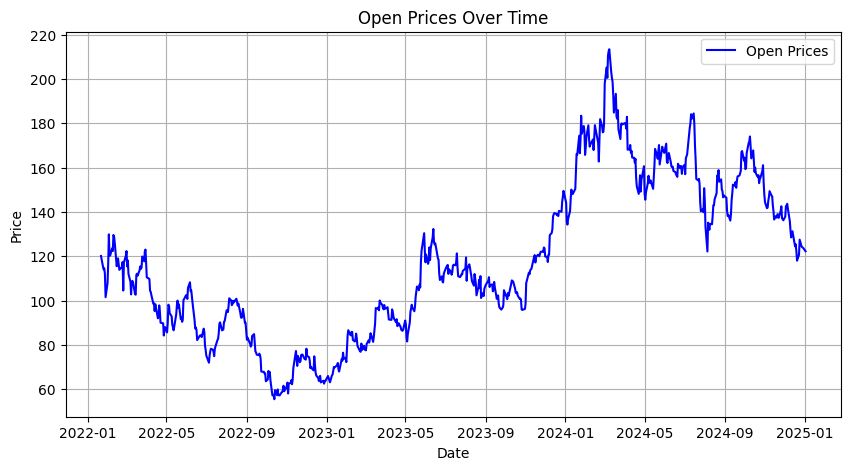

In [22]:
# Plot Open values
plt.figure(figsize=(10, 5))
plt.plot(get_stock_data['Date'], get_stock_data["Open"], label="Open Prices", color="blue")
plt.title("Open Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

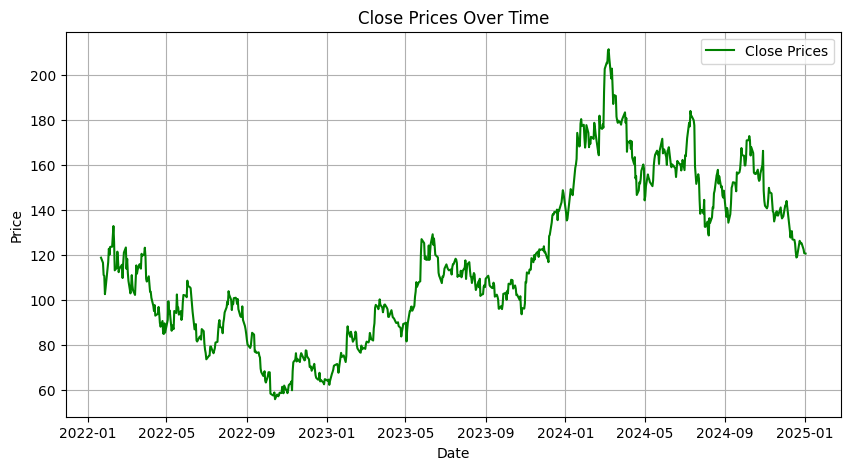

In [23]:
# Plot Open values
plt.figure(figsize=(10, 5))
plt.plot(get_stock_data['Date'], get_stock_data["Close"], label="Close Prices", color="green")
plt.title("Close Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

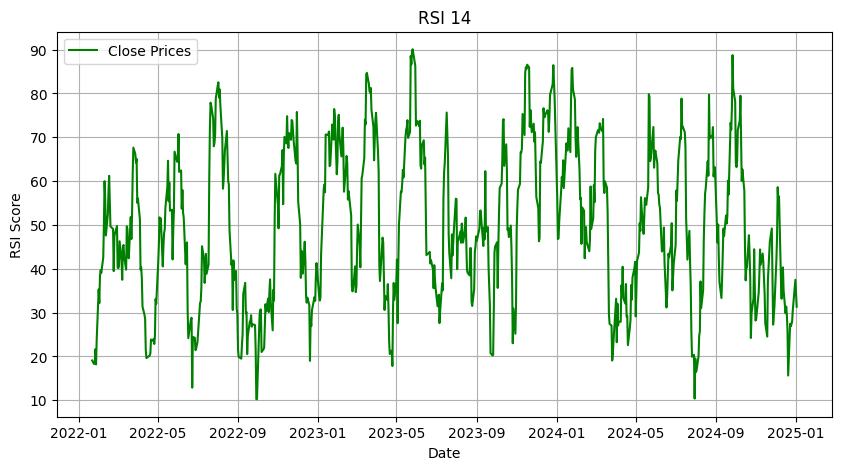

In [24]:
# Plot Open values
plt.figure(figsize=(10, 5))
plt.plot(get_stock_data['Date'], get_stock_data["RSI_14"], label="Close Prices", color="green")
plt.title("RSI 14")
plt.xlabel("Date")
plt.ylabel("RSI Score")
plt.grid(True)
plt.legend()
plt.show()

## Preprocess data

In [25]:
from sklearn.preprocessing import MinMaxScaler
open_scaler = MinMaxScaler()
close_scaler = MinMaxScaler()
volume_scaler = MinMaxScaler()
rsi_scaler = MinMaxScaler()
ma7_scaler = MinMaxScaler()

# Fit each scaler separately on its own column
get_stock_data["Open_scaled"]   = open_scaler.fit_transform(get_stock_data[["Open"]])
get_stock_data["Close_scaled"]  = close_scaler.fit_transform(get_stock_data[["Close"]])
get_stock_data["Volume_scaled"] = volume_scaler.fit_transform(get_stock_data[["Volume"]])
get_stock_data["RSI_14_scaled"] = rsi_scaler.fit_transform(get_stock_data[["RSI_14"]])
get_stock_data["MA_7_scaled"]   = ma7_scaler.fit_transform(get_stock_data[["MA_7"]])

# Then combine columns
scaled_data = get_stock_data[
    ["Open_scaled", "Close_scaled", "Volume_scaled", "RSI_14_scaled", "MA_7_scaled"]
]

<ipython-input-25-93561b97b3a8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  get_stock_data["Open_scaled"]   = open_scaler.fit_transform(get_stock_data[["Open"]])
<ipython-input-25-93561b97b3a8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  get_stock_data["Close_scaled"]  = close_scaler.fit_transform(get_stock_data[["Close"]])
<ipython-input-25-93561b97b3a8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [26]:
scaled_data

Price,Open_scaled,Close_scaled,Volume_scaled,RSI_14_scaled,MA_7_scaled
Ticker,,,,,
13,0.409272,0.404465,0.380298,0.110722,0.486252
14,0.379251,0.389797,0.478358,0.100468,0.466070
15,0.371018,0.355057,0.329739,0.102290,0.445242
16,0.373868,0.352355,0.375842,0.142633,0.420020
17,0.357464,0.300180,0.524912,0.099610,0.391752
...,...,...,...,...,...
749,0.443347,0.444673,0.042581,0.220979,0.440452
750,0.436063,0.445510,0.080447,0.252682,0.440616
751,0.430933,0.427818,0.068874,0.317418,0.441609


In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_data, scaled_data, test_size=0.2, shuffle=False)

## Create sequence

A longer sequence (e.g., 60–120 steps) can capture more historical context and potentially model long‐range patterns. This is especially useful if your data has seasonal or cyclical trends. However, a longer sequence also means the model has more information to process, which can make training slower and can lead to overfitting if not enough regularization is used.

Domain Knowledge: If you know your data has weekly or monthly patterns, choose a length that captures at least a few cycles (e.g. 30 days for monthly trends).

In [28]:
def create_sequences(data, seq_length=90):
    X, y = [], []
    for i in range(len(data) - seq_length):
        # Take the preceding seq_length rows for input
        X.append(data[i : i + seq_length])
        # For the label, we only want [Open, Close] -> indices [0, 1]
        # from data[i + seq_length]
        # Use array indexing to access data by integer location
        y.append(data[i + seq_length, [0, 1]])  # Changed to array indexing
    return np.array(X), np.array(y)

seq_length = 90
train_seq, train_label = create_sequences(X_train.values, seq_length) # Convert X_train to NumPy array
test_seq, test_label   = create_sequences(X_test.values, seq_length)   # Convert X_test to NumPy array

## Define model (Vanilla LSTM)

In [29]:
model = Sequential()
model.add(LSTM(50, return_sequences=True,  input_shape=(train_seq.shape[1], train_seq.shape[2])))
model.add(Dropout(0.1))

model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.1))

model.add(Dense(2))  # e.g. predict [open, close]
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 90, 50)              │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,502 (123.05 KB)

 Trainable params: 31,502 (123.05 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
#7) Early stopping
class LossThresholdCallback(Callback):
    def __init__(self, threshold=0.0001):
        super(LossThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get("loss")
        if current_loss is not None:
            if current_loss < self.threshold:
                print(f"\nTraining stopped because loss < {self.threshold:.6f}")
                self.model.stop_training = True


In [31]:
train_seq.shape[1]

90

In [32]:
print("train_seq.shape =", train_seq.shape)
print("train_label.shape =", train_label.shape)
print("test_seq.shape  =", test_seq.shape)
print("test_label.shape  =", test_label.shape)

train_seq.shape = (502, 90, 5)
train_label.shape = (502, 2)
test_seq.shape  = (59, 90, 5)
test_label.shape  = (59, 2)


In [33]:
loss_threshold_cb = LossThresholdCallback(threshold=0.0005)  # Adjust threshold as needed
history = model.fit(
    train_seq,
    train_label,
    epochs=63,
    batch_size=8,
    validation_data=(test_seq, test_label),
    verbose=1,
    callbacks=[loss_threshold_cb]
)

Epoch 1/63
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 0.0291 - val_loss: 0.0040
Epoch 2/63
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 3/63
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 4/63
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0036 - val_loss: 0.0074
Epoch 5/63
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0034 - val_loss: 0.0060
Epoch 6/63
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0024 - val_loss: 0.0043
Epoch 7/63
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 8/63
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0025 - val_loss: 0.0044
Epoch 9/63
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 10/63
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0022 - val_loss: 0.0065
Epoch 11/63
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 12/63
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0

## Make predictions

In [34]:
test_pred = model.predict(test_seq)  # shape: (num_test_samples, 2)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step


In [35]:
test_pred_open_scaled  = test_pred[:, 0].reshape(-1, 1)
test_pred_close_scaled = test_pred[:, 1].reshape(-1, 1)

# Inverse transform
test_pred_open  = open_scaler.inverse_transform(test_pred_open_scaled)
test_pred_close = close_scaler.inverse_transform(test_pred_close_scaled)

# Flatten if needed
test_pred_open  = test_pred_open.flatten()
test_pred_close = test_pred_close.flatten()

stock_pred_data = get_stock_data.iloc[-(len(test_pred)):].copy()

stock_pred_data["Predicted_Open"]  = test_pred_open
stock_pred_data["Predicted_Close"] = test_pred_close

# For reference, Actual Open/Close from the same rows:
stock_pred_data["Actual_Open"]  = get_stock_data["Open"].iloc[-(len(test_pred)):]
stock_pred_data["Actual_Close"] = get_stock_data["Close"].iloc[-(len(test_pred)):]


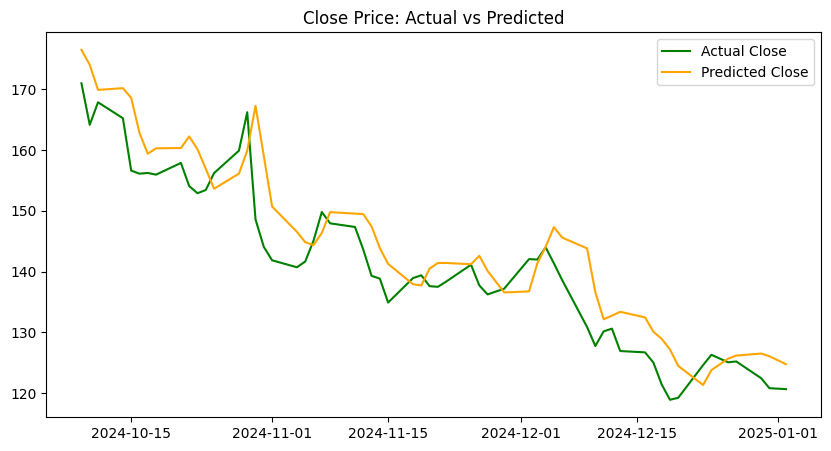

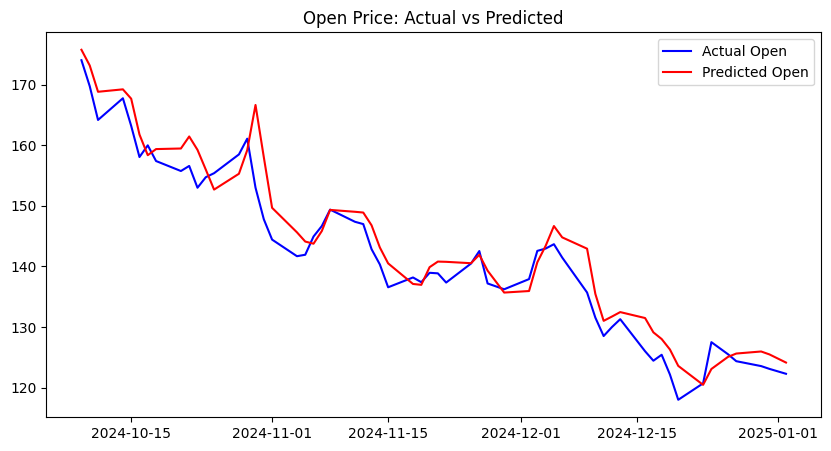

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(stock_pred_data["Date"], stock_pred_data["Actual_Close"], label="Actual Close", color="green")
plt.plot(stock_pred_data["Date"], stock_pred_data["Predicted_Close"], label="Predicted Close", color="orange")
plt.title("Close Price: Actual vs Predicted")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(stock_pred_data["Date"], stock_pred_data["Actual_Open"], label="Actual Open", color="blue")
plt.plot(stock_pred_data["Date"], stock_pred_data["Predicted_Open"], label="Predicted Open", color="red")
plt.title("Open Price: Actual vs Predicted")
plt.legend()
plt.show()


In [37]:
actual_close = get_stock_data["Close"][-len(stock_pred_data["Predicted_Close"]):].values
predicted_close = stock_pred_data["Predicted_Close"].values

predicted_close = predicted_close.reshape(-1, 1)

correlation_close = np.corrcoef(actual_close.flatten(), predicted_close.flatten())[0, 1]  # flatten for 1D
mae_close = mean_absolute_error(actual_close, predicted_close)

print(f"Correlation (Actual vs. Predicted Close): {correlation_close:.4f}")
print(f"Mean Absolute Error (MAE) for Close:       {mae_close:.4f}")

Correlation (Actual vs. Predicted Close): 0.9411
Mean Absolute Error (MAE) for Close:       4.9817


In [42]:
def predict_future(model, open_scaler, close_scaler, rsi_scaler, last_sequence, days=15):
    """
    Predict future [Open, Close] for `days` days based on the last_sequence.
    last_sequence shape = (seq_length, num_features).
    """
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(days):
        # Predict scaled [Open, Close]
        pred_scaled = model.predict(
            current_sequence.reshape(1, current_sequence.shape[0], current_sequence.shape[1])
        )
        # pred_scaled.shape -> (1, 2)
        future_predictions.append(pred_scaled[0])

        # SHIFT the window
        next_row = current_sequence[-1].copy()
        next_row[0] = pred_scaled[0, 0]  # predicted open
        next_row[1] = pred_scaled[0, 1]  # predicted close

        current_sequence = np.append(
            current_sequence[1:],  # drop first row
            [next_row],           # add new predicted row
            axis=0
        )

    future_predictions = np.array(future_predictions)  # shape: (days, 2)

    # Inverse transform each column separately
    pred_open_scaled  = future_predictions[:, 0].reshape(-1, 1)
    pred_close_scaled = future_predictions[:, 1].reshape(-1, 1)

    pred_open  = open_scaler.inverse_transform(pred_open_scaled).flatten()
    pred_close = close_scaler.inverse_transform(pred_close_scaled).flatten()

    # Return (days, 2)
    return np.column_stack([pred_open, pred_close])


In [43]:
 # Let's say you want 10 days into the future
future_days = 10
last_sequence = scaled_data.tail(seq_length).values
# This calls the function (make sure you have `last_sequence` defined properly)
future_preds_10 = predict_future(
    model=model,
    open_scaler=open_scaler,
    close_scaler=close_scaler,
    rsi_scaler=rsi_scaler,  # if you need it (not actually used in this code)
    last_sequence=last_sequence,
    days=future_days
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [44]:
# Get the last date from your dataset
last_date = get_stock_data["Date"].iloc[-1]
# Create date range for the future
future_dates_10 = pd.date_range(start=last_date, periods=future_days+1, freq='D')[1:]

# Build a DataFrame for the 10 future predictions
future_data_10 = pd.DataFrame(
    future_preds_10,
    columns=["Future_Open", "Future_Close"]
)
future_data_10["Date"] = future_dates_10

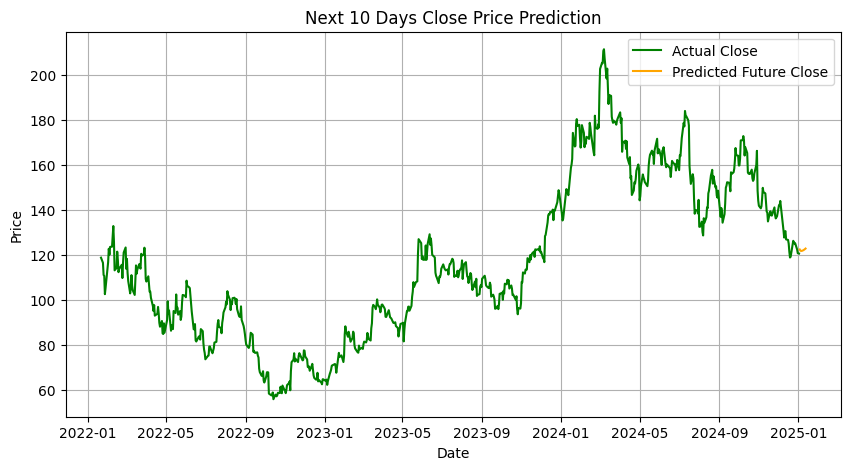

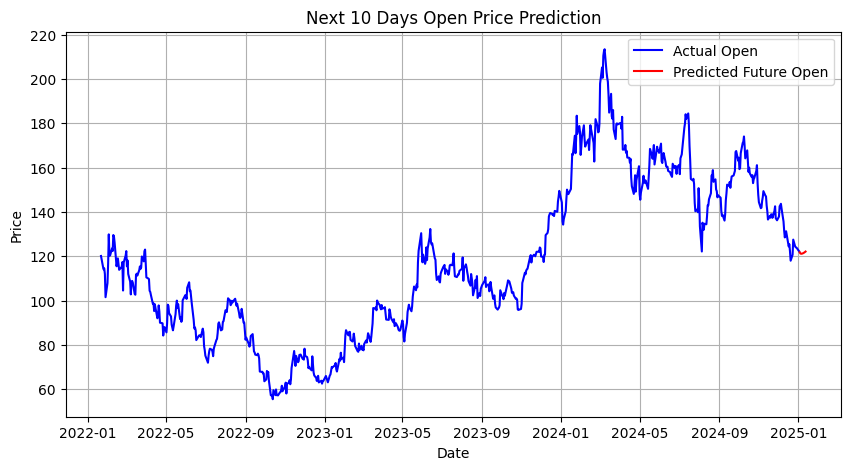

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(get_stock_data["Date"], get_stock_data["Close"], label="Actual Close", color="green")
plt.plot(future_data_10["Date"], future_data_10["Future_Close"], label="Predicted Future Close", color="orange")
plt.title("Next 10 Days Close Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(get_stock_data["Date"], get_stock_data["Open"], label="Actual Open", color="blue")
plt.plot(future_data_10["Date"], future_data_10["Future_Open"], label="Predicted Future Open", color="red")
plt.title("Next 10 Days Open Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

In [46]:
future_data_10.to_csv("future_predictions.csv", index=False)